In [3]:
import urllib
import requests
from IPython.core.display import HTML
def css_styling():
    styles = requests.get('https://raw.githubusercontent.com/saadtony/NumericalMethods/master/styles/custom.css')
    return HTML(styles.text)
css_styling()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
%matplotlib inline
%config InlineBackend.figure_format='svg'
plt.rcParams['animation.html'] = 'html5'

In [401]:
# Domain parameters
nx = 33
ny = 33
Lx = 1.
Ly = 1.
dx = Lx/(nx-1)
dy = Ly/(ny-1)

T0 = 150       # K
cp = 4.18      # kJ/kg-K at 18 centigrade
ρ = 1000       # kg/m^3
k = .6e-3       # kJ/s-m-k

In [402]:
# Boundary velocities
Ut = 1.   # U top wall
Ub = 0.   # U bottom wall
Vl = 0.   # V left wall
Vr = 0.   # V right wall

# Boundary temperature
Tw = 293.1   # K

In [417]:
ψ = np.zeros((ny, nx))
ω = np.zeros((ny, nx))
T = np.ones((ny,nx))

# Temperature initial condition
T *= T0
T[:,0] = Tw

g = 9.81
tol = 1e-3
βr = 1.5
β = 1e-3
maxit = 30
ν = 5e-2
# Set dt from stability conditions
# dt = min(0.25*dx*dx/ν, 4*ν/Ut/Ut)
dt = 1e-3
tend = 5000*dt

In [418]:
def laplacian(f, dx, dy):
    return (f[1:-1,2:]-2*f[1:-1,1:-1]+f[1:-1,:-2])/dx/dx + \
            (f[2:,1:-1]-2*f[1:-1,1:-1]+f[:-2,1:-1])/dy/dy

def ddxc(f, dx):
    return (f[1:-1,2:]-f[1:-1,:-2])/2./dx

def ddyc(f, dy):
    return (f[2:,1:-1]-f[:-2,1:-1])/2./dy

In [419]:
def poisson_solver(ψp, ωp, dx, dy, βr):
    maxit = 30
    tol = 1e-3
    err = 1e3
    mult = βr/2./(dx**2+dy**2)
    it = 0
    psix = np.zeros((ny,nx))
    psiy = np.zeros((ny,nx))
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            psix[j,i] = -2
            psix[j,i-1] = 1
            psix[j,i+1] = 1
            psiy[j,i] = -2
            psiy[j-1,i] = 1
            psiy[j+1,i] = 1
    while err > tol and it < maxit:
        ψk = np.copy(ψp)
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                rhs = (dx*dy)**2*ωp[j,i] + dy**2*(ψp[j,i+1]+ψp[j,i-1]) + dx**2*(ψp[j+1,i]+ψp[j-1,i])
                rhs *= β/2/(dx**2 + dy**2)
                ψp[j,i] = rhs + (1.-β)*ψp[j,i]
#         rhs = (dx**2*dy**2)*ωp[1:-1,1:-1] + dy**2*(ψp[1:-1,2:]+ψp[1:-1,:-2]) + dx**2*(ψp[2:,1:-1]+ψp[:-2,1:-1])
#         rhs *= mult
#         ψp[1:-1,1:-1] = rhs + (1-βr)*ψp[1:-1,1:-1]
#         ψp[0,:]=0
#         ψp[-1,:]=0
#         ψp[:,0]=0
#         ψp[:,-1]=0
        err = np.linalg.norm(ψ-ψk, 2)
        it += 1
    return ψp

In [420]:
## MAIN LOOP ##
t = 0.
while t < tend:
    ωn = np.copy(ω)
    #ψ = poisson_implicit(ωn, dx, dy, nx, ny)
    ψ=poisson_solver(ψ,ωn, dx, dy, βr)
    ω[1:-1,1:-1] = ωn[1:-1,1:-1] + dt*ddxc(ψ,dx)*ddyc(ωn,dy) - dt*ddyc(ψ,dy)*ddxc(ωn,dx) + \
                   dt*ν*laplacian(ωn,dx,dy) - dt*β*g*ddxc(T,dx)
    
    # Apply boundary conditions on vorticity (from Taylor Series expansion for streamfunction on wall)
    ## Vorticity on the left wall
    ω[1:-1,0] = 2./dx**2 * (ψ[1:-1,0]-ψ[1:-1,1]) + 2./dx*Vl
    ## Vorticity on right wall
    ω[1:-1,-1] = 2./dx**2 * (ψ[1:-1,-1]-ψ[1:-1,-2]) - 2./dx*Vr
    ## Vorticity on bottom wall
    ω[0,1:-1] = 2./dy**2 * (ψ[0,1:-1]-ψ[1,1:-1]) + 2./dy*Ub
    ## Vorticity on top wall
    ω[-1,1:-1] = 2./dy**2 * (ψ[-1,1:-1]-ψ[-2,1:-1]) - 2./dy*Ut
    
    Tn = np.copy(T)
    T[1:-1,1:-1] = Tn[1:-1,1:-1] + dt*ddyc(ψ,dy)*ddxc(Tn,dx) + dt*ddxc(ψ,dx)*ddyc(Tn,dy) + \
                   dt*k/(ρ*cp)*laplacian(Tn,dx,dy)
    # Temperature boundary conditions
    ## Top boundary dT/dy=0
    T[-1,1:-1] = T[-2,1:-1]
    ## Bottom boundary, dT/dy=0
    T[0,1:-1] = T[1,1:-1]
    ## Right boundary
    T[-1,1:-1] = T[-2,1:-1]
    ## Left boundary is already accounted for
    
    t += dt

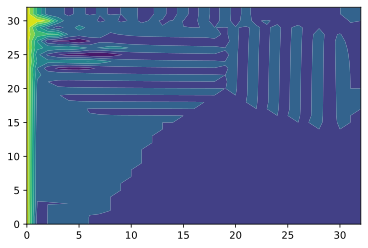

In [421]:
plt.contourf(T)

In [422]:
u = -ddyc(ψ,dx)
v = ddxc(ψ,dy)
vel = np.sqrt(v**2 + u**2)

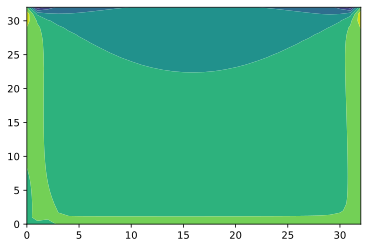

In [423]:
plt.contourf(ω)

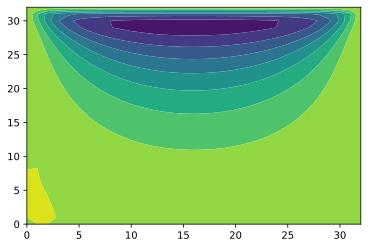

In [424]:
plt.contourf(ψ)

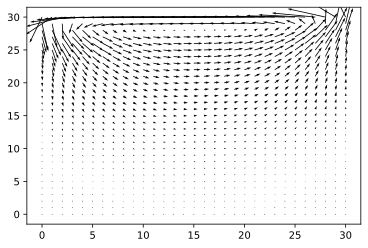

In [425]:
plt.quiver(u,v)

To perform an implicit solution for the Poisson streamfunction equation, it must first be discretized and put into a format that a linear solver can use.

The equation to be solved is:

$$\frac{\partial^{2} \psi }{\partial x^{2}} +\frac{\partial^{2} \psi }{\partial y^{2}} =-\omega$$ 

Discretizing this yields:

$$\frac{1}{\Delta x^{2}\Delta y^{2}} \left( \Delta y^{2}\psi_{i-1,j} -2\Delta y^{2}\psi_{ij} +\Delta y^{2}\psi_{i+1,j} +\Delta x^{2}\psi_{i,j-1} -2\Delta x^{2}\psi_{ij} +\Delta x^{2}\psi_{i,j+1} \right)  =-\omega_{ij}$$

This implies a matrix with 6 diagonals. Alternatively, if the centered terms are combined, it can be made symmetrical about the middle diagonal:

$$ \frac{1}{\Delta x^{2}\Delta y^{2}} \left( \Delta y^{2}\psi_{i-1,j} +\Delta y^{2}\psi_{i+1,j} -2(\Delta x^{2}+\Delta y^{2})\psi_{ij} +\Delta x^{2}\psi_{i,j-1} +\Delta x^{2}\psi_{i,j+1} \right)  =-\omega_{ij} $$

The construction of the coefficient matrix depends on the structure of the solution vector. Python reshapes a vector into a matrix by populating the matrix across axis 1 first (across the rows, or in the x-direction). An example is shown below:

In [96]:
vec = np.arange(12)
vec.reshape(3,4)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

Because of this, you would want a solution vector to contain elements row-by-row. Therefore, to easily reconstruct the 2-dimensional representation of the streamfunction, we want the solution vector to be such that the elements go row-by-row, along axis 1. For a 3x3 matrix, we would want the solution to be:

$$\begin{bmatrix}u_{11}\\ u_{12}\\ u_{13}\\ u_{21}\\ u_{22}\\ u_{23}\\ u_{31}\\ u_{32}\\ u_{33}\end{bmatrix} $$

This means that, for an nxn matrix, you reach a new row every n elements in the solution matrix. Since the discretization of the Poisson equation contains elements that are a row up and a row down from the centered element, this means that a row $i$ of the coefficient matrix will contain entries located at $i-n$, $i-1$, $i$, $i+1$, and $i+n$.

Let's look at row 1 for a 3x3 domain, which corresponds to a 9x9 coefficient matrix. Boundary rows and columns are not included.

$$\begin{bmatrix}1&1&0&1&0&0&0&0&0\\ 1&1&1&0&1&0&0&0&0\\ 0&1&1&0&0&1&0&0&0\\ 1&0&0&1&1&0&1&0&0\\ 0&1&0&1&1&1&0&1&0\\ 0&0&1&0&1&1&0&0&1\\ 0&0&0&1&0&0&1&1&0\\ 0&0&0&0&1&0&1&1&1\\ 0&0&0&0&0&1&0&1&1\end{bmatrix} \begin{bmatrix}u11\\ u12\\ u13\\ u21\\ u22\\ u23\\ u31\\ u32\\ u33\end{bmatrix} $$

Here, the main diagonal entry represents the element of the solution vector on that row. For example, in the 5th row, the main diagonal entry is $u_{22}$. A clear pattern for creation of the matrix emerges. For Dirichlet boundary conditions, they can be included by simply having a 1 only on the diagonal at positions where there is a boundary element. For an nxn matrix, these occur at $u_{0,j}, u_{n,j}, u_{i,0}$ and $u_{i,n}$. Consider a 2x2 interior matrix within a 4x4 matrix, with Dirichlet boundary conditions:

$$\begin{bmatrix}1&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\ 0&1&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\ 0&0&1&0&0&0&0&0&0&0&0&0&0&0&0&0\\ 0&0&0&1&0&0&0&0&0&0&0&0&0&0&0&0\\ 0&0&0&0&1&0&0&0&0&0&0&0&0&0&0&0\\ 0&1&0&0&1&1&1&0&0&1&0&0&0&0&0&0\\ 0&0&1&0&0&1&1&1&0&0&1&0&0&0&0&0\\ 0&0&0&0&0&0&0&1&0&0&0&0&0&0&0&0\\ 0&0&0&0&0&0&0&0&1&0&0&0&0&0&0&0\\ 0&0&0&0&0&1&0&0&1&1&1&0&0&1&0&0\\ 0&0&0&0&0&0&1&0&0&1&1&1&0&0&1&0\\ 0&0&0&0&0&0&0&0&0&0&0&1&0&0&0&0\\ 0&0&0&0&0&0&0&0&0&0&0&0&1&0&0&0\\ 0&0&0&0&0&0&0&0&0&0&0&0&0&1&0&0\\ 0&0&0&0&0&0&0&0&0&0&0&0&0&0&1&0\\ 0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&1\\\end{bmatrix} \begin{bmatrix}u00\\ u01\\ u02\\ u03\\ u10 \\u11\\ u12\\ u13\\ u20\\ u21\\ u22\\ u23\\ u30\\ u31\\ u32\\ u33\end{bmatrix} $$



In [113]:
def adi_solver_naive(omega, dx, dy, nx, ny):
    d = np.ones(nx*ny)*-2*(dx**2 + dy**2)
    ud = np.ones(nx*ny-1)*dx**2
    uud = np.ones(nx*ny-nx)*dx**2
    ld = np.ones(nx*ny-1)*dy**2
    lld = np.ones(nx*ny-nx)*dy**2
    for i in range(nx, nx*ny-nx):
        if nx 
    psi = np.diag(d) + np.diag(ud,k=1) + np.diag(uud,k=nx) + np.diag(ld,k=-1) + np.diag(lld,k=-ny)
    # Alter matrix to accept Dirichlet boundary conditions
#     psi[0,:] = 0
#     psi[-1,:] = 0
#     psi[0,0] = 1
#     psi[-1,-1] = 1
    return psi

In [114]:
psisol = adi_solver_naive(1,1,1,4,4)

In [115]:
print(psisol)

[[-4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4. 

The naive ADI solver above gets the diagonals in the right places. The coefficients are also correct for the case where $\Delta x = \Delta y$. What we now need is to put the boundary conditions in. The top and bottom nx+1 rows just have ones on the diagonal. Additionally, every nx row is a 0 for the adjacent off-diagonal entries.

In [430]:
def poisson_implicit(omega, dx, dy, nx, ny):
    '''
    Function to create a diagonal matrix representation of the Poisson streamfunction equation for cavity flow. 
    The solution vector is structured such that Python's reshape function will turn it into a properly 
    structured square matrix. Indices start with zero at the top, but as long as the top boundary conditions
    are appropriately located in the 'b' vector in Ax = b, then the reshaped matrix will have the proper 
    orientation.
    
    This function is written for Dirichlet boundary conditions where the streamfunction is zero on all boundaries.
    '''
    om = omega.ravel()
    d = np.ones(nx*ny)*-2*(dx**2 + dy**2)
    ud = [1 for i in range(nx)]
    ud[0] = 0
    ud[-1] = 0
    uud = [1 for i in range(nx)]
    uud[0] = 0
    uud[-1] = 0
    ld = [1 for i in range(nx)]
    ld[0] = 0
    ld[-1] = 0
    lld = [1 for i in range(nx)]
    lld[0] = 0
    lld[-1] = 0
    n_off_diag = (nx*ny - 2*nx)//nx
    ud = ([0 for i in range(nx)] + ud*n_off_diag + [0 for i in range(nx-1)])
    uud = ([0 for i in range(nx)] + uud*n_off_diag)
    ld = ([0 for i in range(nx-1)] + ld*n_off_diag + [0 for i in range(nx)])
    lld = (lld*n_off_diag + [0 for i in range(nx)])
     
    psi = np.diag(d) + np.diag(ud,k=1)*dx**2 + np.diag(uud,k=nx)*dx**2 + \
          np.diag(ld,k=-1)*dy**2 + np.diag(lld,k=-ny)*dy**2
    for i in range(nx):
        psi[i,:] = 0
        psi[i,i] = 1
        om[i] = 0
    for i in range(nx*ny-1, nx*ny-nx-1, -1):
        psi[i,:] = 0
        psi[i,i] = 1
        om[i] = 0
    for i in range(nx, nx*ny-nx):
        if (i % nx == 0) or (i % nx == nx-1):
            psi[i,:] = 0
            psi[i,i] = 1
            om[i] = 0
    psisol = np.linalg.solve(-psi, om)
    
    return psisol.reshape(nx,ny)

In [431]:
psisol = poisson_implicit(ω, dx, dy, nx, ny)

In [432]:
print(psisol)

[[    -0.             -0.             -0.         ...     -0.
      -0.             -0.        ]
 [    -0.          -2267.62289465  -4608.40879219 ...  -4740.51314958
   -2370.96473763     -0.        ]
 [    -0.          -4567.05533079  -9248.80006735 ...  -9525.08771992
   -4761.36737287     -0.        ]
 ...
 [    -0.         -25862.4699109  -53094.78676455 ... -56051.89105359
  -27667.84430766     -0.        ]
 [    -0.         -18022.38465014 -34423.78823356 ... -36434.99637302
  -19536.47785954     -0.        ]
 [    -0.             -0.             -0.         ...     -0.
      -0.             -0.        ]]


In [429]:
ψ

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  4.83270014e-05,  2.35062056e-05, ...,
        -2.25660914e-05, -7.83368515e-06,  0.00000000e+00],
       [ 0.00000000e+00,  7.53819180e-05,  3.67913924e-05, ...,
        -6.20608405e-05, -2.26762407e-05,  0.00000000e+00],
       ...,
       [ 0.00000000e+00, -6.79605863e-03, -1.44012080e-02, ...,
        -1.54241960e-02, -7.51648201e-03,  0.00000000e+00],
       [ 0.00000000e+00, -7.92837775e-03, -1.40484750e-02, ...,
        -1.49447363e-02, -8.78294827e-03,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [381]:
dt

0.001